# 0. Imports

In [238]:
import polars as pl

from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns

In [249]:
pl.Config.set_fmt_float("full")
sns.set_style('darkgrid')

# 1. Importação dos dados
Importação e primeiros tratamentos dos dados

In [88]:
#importanto e fazendo tratamentos iniciais
df = (pl.read_csv(
    '../m1-analise-exploratoria/data/AIH_processamento.csv', 
    separator=';', 
    truncate_ragged_lines=True, 
    encoding='ISO-8859-1', 
    skip_rows=3, 
    null_values=['-'], 
    row_count_name='index')
.filter(
    pl.col('index') <= 26
)
.select(
    pl.col("index"),
    pl.col("Unidade da Federação").str.replace(r"[0-9]+ ", "").alias("uf"),
    pl.col("*")
        .exclude("index", "Unidade da Federação", "Total")
        .str.replace(",", ".")
        .cast(pl.Float64)
))

In [90]:
def map_region(estado):
    return ('Sudeste' if estado in ['São Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Espírito Santo'] else
            'Sul' if estado in ['Paraná', 'Rio Grande do Sul', 'Santa Catarina'] else 
            'Centro-Oeste' if estado in ['Goiás', 'Distrito Federal', 'Mato Grosso do Sul', 'Mato Grosso'] else 
            'Norte' if estado in ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins'] else 
            'Nordeste')

# Aplicar o mapeamento e criar uma nova coluna 'Regiao'
df = df.with_columns(
    pl.col('uf').map_elements(map_region).alias('regiao')
)

In [91]:
df.head()

index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,…,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,"""Rondônia""",1.3885e6,2.9313e6,1.5417e6,1.5253e6,1.6460e6,1.4062e6,3.0653e6,3.2315e6,3.1172e6,3.0684e6,2.8258e6,2.9312e6,2.8853e6,2.8601e6,3.6849e6,3.6073e6,3774356.6,3.7067e6,3.7632e6,3.5336e6,3.6050e6,3.9070e6,3.9398e6,3.9011e6,3.6844e6,3.6230e6,3890461.9,4.1935e6,4.5344e6,4.4512e6,4.8746e6,4.4608e6,5.0679e6,4.5111e6,4394680.5,…,1.1954e7,1.1888e7,1.0328e7,8.0680e6,9.4865e6,9.0201e6,9.8616e6,9.8123e6,1.4953e7,1.5564e7,1.6492e7,1.5573e7,1.4743e7,1.3055e7,1.2115e7,9.7680e6,1.1098e7,1.1210e7,1.1095e7,1.2432e7,1.2174e7,1.1122e7,1.0348e7,8.6713e6,9.8645e6,9.1456e6,1.0293e7,9.1605e6,9.3242e6,1.1135e7,1.0253e7,8.5640e6,1.1146e7,1.0349e7,1.3496e7,1.0017e7,"""Norte"""
1,"""Acre""",902416.0,1.4972e6,1.7940e6,1.7305e6,1.8194e6,1.828496e6,2.5118e6,2.0891e6,2.2757e6,1.9239e6,1756986.8,2.2356e6,2.4971e6,2.2536e6,2.1227e6,2.8343e6,2.7221e6,2.4328e6,2.6302e6,2.307579e6,null,2.8265e6,2.1708e6,2.5415e6,2.4910e6,1954473.9,2.3900e6,2654878.6,2.8441e6,2.3362e6,2.1251e6,2.4303e6,2.3777e6,2.1847e6,2468452.9,…,3915193.2,3.6401e6,3.3912e6,4.0443e6,3276590.1,3.6970e6,3.7157e6,3.5384e6,4.0770e6,6.3076e6,6.3545e6,3.4617e6,4979239.3,4.1388e6,4.2600e6,3.8286e6,2.8897e6,3.1382e6,3.5474e6,3.4243e6,3.5848e6,3791898.2,4.5237e6,2.9781e6,2.8026e6,3.7933e6,3310293.3,3.5116e6,4.1110e6,3999023.9,3.4924e6,4.2619e6,4.9275e6,4.7012e6,4.8450e6,5.124899e6,"""Norte"""
2,"""Amazonas""",4.7355e6,7.1190e6,8.1966e6,8.2594e6,7831399.9,8.4773e6,9.3689e6,9352532.7,9.3631e6,8.6183e6,6.5555e6,7.7776e6,7.4031e6,6.6833e6,9927781.2,8.8445e6,9.0790e6,8.8329e6,9.3734e6,9.5783e6,9.7306e6,9.1793e6,8.3146e6,9.0504e6,9.4195e6,8.6802e6,9.1681e6,9897901.8,9.6514e6,1.0855e7,1.0417e7,8.7183e6,8.2216e6,9.6140e6,9.9276e6,…,1.9770e7,1.8070e7,1.7852e7,1.6419e7,1.9904e7,1.7795e7,2.1622e7,2.6903e7,2.6598e7,2.2733131e7,2.5883e7,2.6200e7,2.4066e7,2.2720e7,2.1121e7,1.6901e7,1.8372e7,1.7784e7,1.5534e7,1.8217e7,1.9742e7,1.8985e7,2.0498e7,1.6097e7,2.1997e7,2.0891e7,2.3220e7,1.9802e7,2.0550e7,2.2174e7,2.0568e7,1.6473e7,2.1490e7,1.9092e7,2.0893e7,2.0489e7,"""Norte"""
3,"""Roraima""",657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1.1918e6,1.0562e6,1.2443e6,1.0857e6,969528.54,1393226.7,1.2737e6,1552638.5,1.4906e6,1596751.8,1.8490e6,1.7016e6,1.1647e6,1.4348e6,1.6038e6,1437340.8,1.3321e6,1.9005e6,1.9339e6,1.7740e6,1.8047e6,1.8466e6,1.6435e6,1.8432e6,1.8079e6,1.6749e6,…,3015488.3,2.8265e6,2.9280e6,3.0903e6,3.6210e6,3.4545e6,3.2669e6,3.5198e6,4437161.1,5.1714e6,4.2663e6,3.1040e6,3.7433e6,3.7819e6,3.1508e6,3.1856e6,3.0228e6,3.1292e6,3.0245e6,3.0972e6,3.3286e6,3.7204e6,4.0579e6,497359.98,3.4548e6,4.5950e6,4.7986e6,4401306.6,4.1733e6,4.4160e6,4.4868e6,3.8874e6,4.5973e6,4.4563e6,3.7039e6,2.9905e6,"""Norte"""
4,"""Pará""",1.8865e7,1.9554e7,2.1937e7,2.0843e7,2.3250e7,2.3241e7,2.4002e7,2.3341e7,2.5172e7,2.4012e7,2.1526e7,2.3897e7,2.4613e7,2.4016e7,2.6624e7,2.6479e7,2.6366e7,2.5441e7,2.8079e7,2.7589e7,2.7968e7,2.8431e7,2.5432e7,2.6406e7,2.5842e7,2.6527e7,2.7433e7,2.5754e7,2.7515e7,2.6934e7,2.6668e7,2.6607e7,2.7227e7,2.7186e7,2.7020e7,…,

## 1.1. Importação dos dados - População IBGE

In [109]:
pop_ibge = (pl.read_excel(
    'data/pop_censo_23.xlsx',
    read_csv_options = {
        'truncate_ragged_lines': True,
        'skip_rows': 3,
        'row_count_name': 'index'
    }
)
.filter(
    (pl.col('index') <= 32) & (pl.col('index') >= 6)
)
.select(
    pl.col("index"),
    pl.col("").alias('uf'),
    pl.col("População residente (Pessoas)").alias('pop')
))
pop_ibge

index,uf,pop
u32,str,i64
6,"""Rondônia""",1581016
7,"""Acre""",830026
8,"""Amazonas""",3941175
9,"""Roraima""",636303
10,"""Pará""",8116132
11,"""Amapá""",733508
12,"""Tocantins""",1511459
13,"""Maranhão""",6775152
14,"""Piauí""",3269200


## 1.2 Mesclando dataframes

In [176]:
df_merged = df.join(pop_ibge[['uf', 'pop']], on='uf', how='left')
df_merged

index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,…,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao,pop
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64
0,"""Rondônia""",1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.6,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.9,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.5,…,11887993.85,10328280.19,8068024.57,9486450.48,9020062.64,9861592.32,9812340.48,14953391.13,15563729.11,16492196.14,15572901.51,14742747.37,13054732.77,12115394.39,9768041.54,11098424.77,11210055.47,11094746.21,12431841.65,12174377.23,11121899.06,10347874.99,8671261.99,9864471.65,9145590.72,10292958.39,9160542.91,9324183.87,11135187.34,10253476.82,8564028.28,11145654.32,10349162.16,13496368.3,10016527.33,"""Norte""",1581016
1,"""Acre""",902416,1497206.26,1794028.48,1730469.42,1819443.92,1828496,2511754.59,2089107.14,2275708.53,1923886.57,1756986.8,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579,null,2826477.02,2170791.18,2541526.44,2491042.33,1954473.9,2389996.38,2654878.6,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.9,…,3640142.82,3391242.21,4044321.44,3276590.1,3696997.31,3715723.12,3538427.92,4077045.92,6307616.67,6354514.15,3461663.11,4979239.3,4138751.64,4260017.06,3828566.34,2889654.47,3138245.58,3547361.84,3424337.76,3584824.97,3791898.2,4523687.48,2978062.37,2802612.38,3793316.97,3310293.3,3511587.05,4110985.51,3999023.9,3492410.89,4261938.15,4927482.49,4701182.54,4845006.75,5124899,"""Norte""",830026
2,"""Amazonas""",4735529.42,7118990.57,8196635.49,8259378.42,7831399.9,8477273.62,9368858.72,9352532.7,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.2,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.8,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,…,18069587.18,17852221.73,16419160.7,19903821.77,17794528.56,21621697.26,26903413.08,26598262.21,22733131,25882861.87,26200089.42,24066337.32,22720450.82,21120609.03,16901290.05,18371952.43,17783646.65,15534203.5,18217410.79,19742224.74,18984786.74,20497811.6,16096601.99,21996502.4,20890677.33,23220479.51,19801969.84,20549906.88,22174482.71,20568381.18,16473235.07,21490357.77,19091911.73,20893498.11,20489269.19,"""Norte""",3941175
3,"""Roraima""",657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.7,1273734.17,1552638.5,1490587.74,1596751.8,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.8,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,…,2826486.18,2928043.91,3090313.73,3621031.05,3454460.94,3266928.47,3519773.73,4437161.1,5171370.92,4266254.94,3103979.88,3743330.65,3781921.16,3150835.05,3185551.53,3022781.41,3129225.29,3024454.61,3097211.89,3328597.91,372

Exibindo o último mês de registro junto com o UF e a população

In [177]:
df_merged[:, [1, -3, -1]]

uf,2023/Jun,pop
str,f64,i64
"""Rondônia""",10016527.33,1581016
"""Acre""",5124899,830026
"""Amazonas""",20489269.19,3941175
"""Roraima""",2990546.28,636303
"""Pará""",39589979.97,8116132
"""Amapá""",null,733508
"""Tocantins""",750623.04,1511459
"""Maranhão""",34083431.66,6775152
"""Piauí""",21718298.31,3269200


Descrevendo os dados do dataframe df_merged

In [178]:
df_merged.describe()

describe,index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,…,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao,pop
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""count""",27,"""27""",27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,…,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,"""27""",27
"""null_count""",0,"""0""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"""0""",0
"""mean""",13,null,15126846.638148146,22710158.118888885,24594187.34740741,25431957.83037037,26511245.907037035,27858576.431111105,28332973.509629633,27800320.306666665,27887505.26481481,27148854.290000003,24748781.93296297,28739553.211851854,27779578.572962966,28021517.94814815,31180857.913703702,30559470.481111113,32067740.963703696,31580672.711481474,32611202.767037038,33068227.206666674,33594787.21192308,32419807.373703696,32189393.278518517,31167981.218518518,31560092.181111116,29928809.929629635,32999254.935925927,33416032.92518518,33861926.6362963,32998566.051481478,33776633.08296296,34508112.22148148,33571030.219259255,33202549.08666667,…,56131497.69111112,54777149.0811111,54928986.3411111,54561996.98740741,53953050.37666667,57100927.73148146,57598806.922592595,66933296.56444445,75547668.96481481,80204335.33629629,83626283.43037036,82560514.88074073,76573730.37407407,68445439.10444444,62337051.49185186,59524200.7811111,58202188.53777777,58014586.941851854,58289688.30296297,58306003.65518519,56675828.562222235,57931505.94481481,55740784.01296296,59825159.63925926,61346762.03925926,60614300.511481486,60807375.45444445,58619545.96407408,60292495.95444445,59691390.74814816,56107284.989999995,62806503.967777774,59761203.466666654,62540150.90814814,64151112.65846154,null,7520833.777777778
"""std""",7.937253933193772,null,19159188.30172331,30879444.0650368,32516725.689190224,33339066.25173231,37540771.630838655,38676893.04388564,39292968.91159118,37748913.796220645,38226540.645572454,36671387.56302291,34302651.63989868,39263230.84483367,37988016.9389312,38472973.829222105,43107877.67301846,41375865.00943748,43820473.72134735,43730638.4130753,44931951.46176282,46760267.579265304,44890690.6396743,44723736.90980795,44657514.58509976,42490731.83650135,43451336.504097134,41128727.38480013,45902372.56177346,46619168.64526079,46583768.83349485,45800691.66246197,46621043.55559864,47569222.68526957,47049920.204067685,45173519.54379192,…,72130030.41842511,72983900.15965569,72517822.48560314,70552455.44285235,69763282.33482341,74561972.25737955,73754197.68670008,85135986.65197964,98344657.92337629,105293790.83581574,109357759.27081871,107798249.40949422,97980285.793472,85236862.96465392,77180953.73101471,73968578.38746409,72563099.26989065,72578180.7037612,71715953.84551106,73626027.8987657,70721994.38108385,72541679.043895,70263658.9656886,76352225.64253148,77894282.5913045,77834604.8182245,78335241.26507741,75145900.6609037,76180871.66141365,75431388.95592572,70878782.4267064,80162821.49409103,75249265.54540557,78468638.82926828,82016501.16442016,null,8925236.334843967
"""min""",0,"""Acre"

# 2. Visualização dos dados

In [203]:
df2 = df_merged.clone()

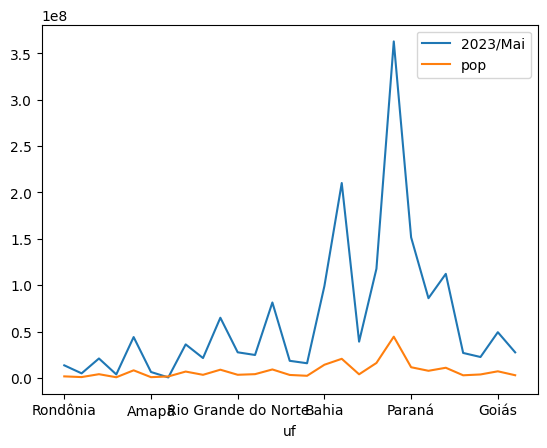

In [197]:
df_aux = df2[:, [1, -4, -1]].to_pandas().set_index('uf')
df_aux.plot();

In [207]:
#criando no Dataframe a coluna total e o gasto médio por habitante
df2 = df2.with_columns(
        pl.sum_horizontal(
            pl.col(pl.Float64).fill_null(0)
        ).alias('total')
    ).with_columns(
        (
            pl.col('total')/pl.col('pop')/186
        ).alias('total_per_capita_media')
    )

### Desafio:
- Deixar o gráfico mais arrumado com legenda adequada, títulos, eixos e ordenar do maior gasto por habitante para o menor
- Sinalizar a média geral no gráfico
- Ordenar por número de habitantes

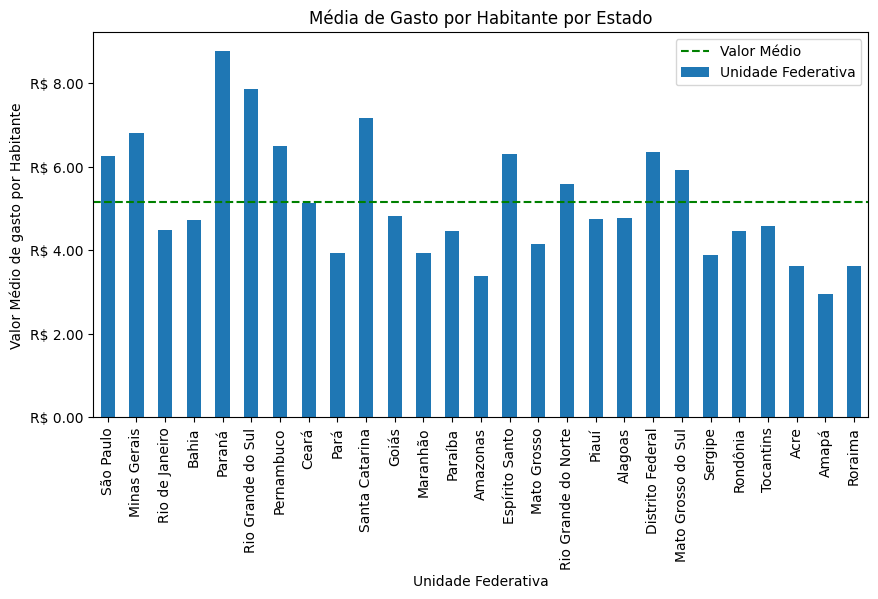

In [237]:
df_aux = df2[:, [1, -1, -3]].sort(by="pop", descending=True).to_pandas().set_index('uf')

ax = df_aux['total_per_capita_media'].plot(
    kind='bar', 
    figsize=(10, 5),
    label='Unidade Federativa')
ax.axhline(y=df_aux['total_per_capita_media'].mean(), color='green', linestyle='--', label='Valor Médio')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('Unidade Federativa')
ax.set_ylabel('Valor Médio de gasto por Habitante')

ax.title.set_text('Média de Gasto por Habitante por Estado')
ax.legend(loc='best', bbox_to_anchor=(1,1))

plt.show()

## 2.1 Visualização com Seaborn

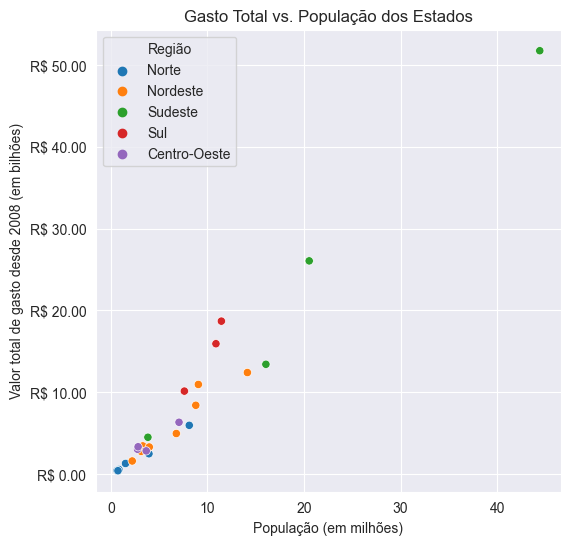

In [255]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data = df2.select(
        pl.col('pop')/1_000_000,
        pl.col('total')/1_000_000_000,
        pl.col('regiao')
    ),
    x='pop',
    y='total',
    hue='regiao'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Valor total de gastos (em bilhões)')

ax.title.set_text('Gasto Total desde 2008 vs. População dos Estados')
ax.legend(loc='best', title='Região')

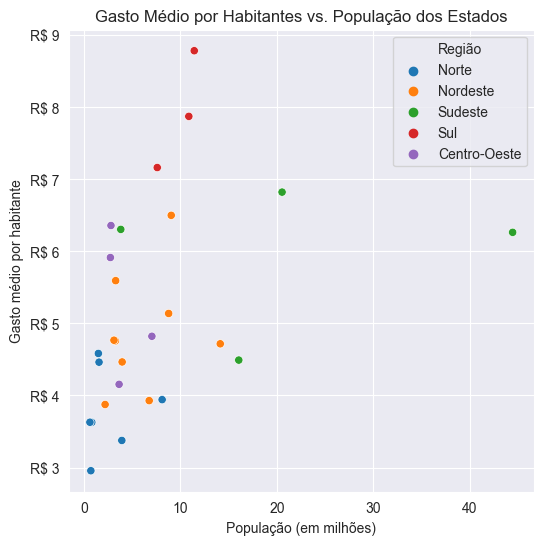

In [259]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data = df2.select(
        pl.col('pop')/1_000_000,
        pl.col('total_per_capita_media'),
        pl.col('regiao')
    ),
    x='pop',
    y='total_per_capita_media',
    hue='regiao'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.0f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Gasto médio por habitante')

ax.title.set_text('Gasto Médio por Habitantes vs. População dos Estados')
ax.legend(loc='best', title='Região');

### Desafio
- Plotar um gráfico comparando períodos diferentes de gasto

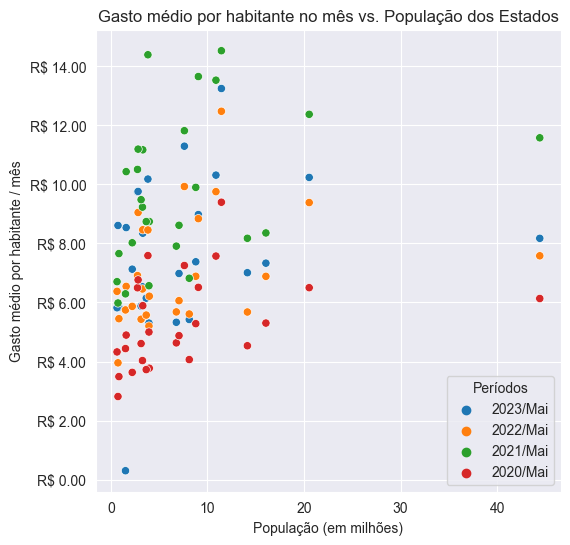

In [288]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    df2.select(
        pl.col('pop')/1_000_000,
        pl.col(['2023/Mai', '2022/Mai', '2021/Mai', '2020/Mai'])/pl.col('pop'),
    ).melt(id_vars=['pop']),
    x='pop',
    y='value',
    hue='variable'
);

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('R$ {x:,.2f}'))

ax.set_xlabel('População (em milhões)')
ax.set_ylabel('Gasto médio por habitante / mês')

ax.title.set_text('Gasto médio por habitante no mês vs. População dos Estados')
ax.legend(loc='best', title='Períodos');

In [262]:
df2

index,uf,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,…,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set,2021/Out,2021/Nov,2021/Dez,2022/Jan,2022/Fev,2022/Mar,2022/Abr,2022/Mai,2022/Jun,2022/Jul,2022/Ago,2022/Set,2022/Out,2022/Nov,2022/Dez,2023/Jan,2023/Fev,2023/Mar,2023/Abr,2023/Mai,2023/Jun,regiao,pop,total,total_per_capita_media
u32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64
0,"""Rondônia""",1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.6,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.9,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.5,…,8068024.57,9486450.48,9020062.64,9861592.32,9812340.48,14953391.13,15563729.11,16492196.14,15572901.51,14742747.37,13054732.77,12115394.39,9768041.54,11098424.77,11210055.47,11094746.21,12431841.65,12174377.23,11121899.06,10347874.99,8671261.99,9864471.65,9145590.72,10292958.39,9160542.91,9324183.87,11135187.34,10253476.82,8564028.28,11145654.32,10349162.16,13496368.3,10016527.33,"""Norte""",1581016,1312080936.4200003,4.461813531870157
1,"""Acre""",902416,1497206.26,1794028.48,1730469.42,1819443.92,1828496,2511754.59,2089107.14,2275708.53,1923886.57,1756986.8,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579,null,2826477.02,2170791.18,2541526.44,2491042.33,1954473.9,2389996.38,2654878.6,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.9,…,4044321.44,3276590.1,3696997.31,3715723.12,3538427.92,4077045.92,6307616.67,6354514.15,3461663.11,4979239.3,4138751.64,4260017.06,3828566.34,2889654.47,3138245.58,3547361.84,3424337.76,3584824.97,3791898.2,4523687.48,2978062.37,2802612.38,3793316.97,3310293.3,3511587.05,4110985.51,3999023.9,3492410.89,4261938.15,4927482.49,4701182.54,4845006.75,5124899,"""Norte""",830026,560137710.3400002,3.628191245026164
2,"""Amazonas""",4735529.42,7118990.57,8196635.49,8259378.42,7831399.9,8477273.62,9368858.72,9352532.7,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.2,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.8,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,…,16419160.7,19903821.77,17794528.56,21621697.26,26903413.08,26598262.21,22733131,25882861.87,26200089.42,24066337.32,22720450.82,21120609.03,16901290.05,18371952.43,17783646.65,15534203.5,18217410.79,19742224.74,18984786.74,20497811.6,16096601.99,21996502.4,20890677.33,23220479.51,19801969.84,20549906.88,22174482.71,20568381.18,16473235.07,21490357.77,19091911.73,20893498.11,20489269.19,"""Norte""",3941175,2475571041.9900007,3.3770440873924747
3,"""Roraima""",657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.7,1273734.17,1552638.5,1490587.74,1596751.8,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.8,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,…,3090313.73,3621031.05,3454460.94,3266928.47,3519773.73,4437161.1,5171370.92,4266254.94,3103979.88,3743330.65,3781921.16,3150835.05,3185551.53,3022781.41,3129225.29,302445